<a href="https://colab.research.google.com/github/iranfromiran/computer-vision-brain-tumor/blob/main/ai_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision
!pip install torchmetrics

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics import Precision, Recall, F1Score
from sklearn.metrics import classification_report
from torchvision.models import resnet50
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dir = '/content/drive/My Drive/Colab Notebooks/experiment data/training'
test_dir = '/content/drive/My Drive/Colab Notebooks/experiment data/testing'

from google.colab import drive
drive.mount('/content/drive')

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = datasets.ImageFolder(root=train_dir).classes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


In [ ]:
class ResNet50CBAM(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet50CBAM, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cbam = CBAM(2048)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.cbam(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x

model = ResNet50CBAM(num_classes=4).to(device)

for param in model.resnet.conv1.parameters():
    param.requires_grad = False
for param in model.resnet.layer1.parameters():
    param.requires_grad = False
for param in model.resnet.layer2.parameters():
    param.requires_grad = False
for param in model.resnet.layer3.parameters():
    param.requires_grad = False

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50CBAM(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# Loss and optimizer (paper uses Adam with lr=0.0001)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# Training loop (paper trains for 50 epochs, we’ll start with 20 for subset)
num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_train_loss += loss.item()
        if i % 10 == 9:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_preds = []
    val_labels_list = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_preds.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    val_prec = Precision(task="multiclass", num_classes=4, average='macro').to(device)
    val_rec = Recall(task="multiclass", num_classes=4, average='macro').to(device)
    val_f1 = F1Score(task="multiclass", num_classes=4, average='macro').to(device)
    val_preds_tensor = torch.tensor(val_preds).to(device)
    val_labels_tensor = torch.tensor(val_labels_list).to(device)
    val_prec_score = val_prec(val_preds_tensor, val_labels_tensor)
    val_rec_score = val_rec(val_preds_tensor, val_labels_tensor)
    val_f1_score = val_f1(val_preds_tensor, val_labels_tensor)
    val_precisions.append(val_prec_score.item())
    val_recalls.append(val_rec_score.item())
    val_f1s.append(val_f1_score.item())

    print(f'Epoch [{epoch+1}/{num_epochs}] - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_prec_score:.4f}, Val Recall: {val_rec_score:.4f}, Val F1: {val_f1_score:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/2resnet50_cbam.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break
print('Training Finished!')

Epoch [1/20], Step [10/11], Loss: 1.1501
Epoch [1/20] - Val Loss: 1.2845, Val Accuracy: 50.00%, Val Precision: 0.5310, Val Recall: 0.4775, Val F1: 0.4422
Epoch [2/20], Step [10/11], Loss: 0.5219
Epoch [2/20] - Val Loss: 0.8744, Val Accuracy: 67.44%, Val Precision: 0.7224, Val Recall: 0.6585, Val F1: 0.6199
Epoch [3/20], Step [10/11], Loss: 0.1741
Epoch [3/20] - Val Loss: 0.4467, Val Accuracy: 84.88%, Val Precision: 0.8569, Val Recall: 0.8469, Val F1: 0.8484
Epoch [4/20], Step [10/11], Loss: 0.0651
Epoch [4/20] - Val Loss: 0.2582, Val Accuracy: 88.37%, Val Precision: 0.8945, Val Recall: 0.8885, Val F1: 0.8852
Epoch [5/20], Step [10/11], Loss: 0.0262
Epoch [5/20] - Val Loss: 0.1933, Val Accuracy: 95.35%, Val Precision: 0.9552, Val Recall: 0.9545, Val F1: 0.9544
Epoch [6/20], Step [10/11], Loss: 0.0126
Epoch [6/20] - Val Loss: 0.1980, Val Accuracy: 91.86%, Val Precision: 0.9141, Val Recall: 0.9204, Val F1: 0.9153
Epoch [7/20], Step [10/11], Loss: 0.0079
Epoch [7/20] - Val Loss: 0.1876, Va

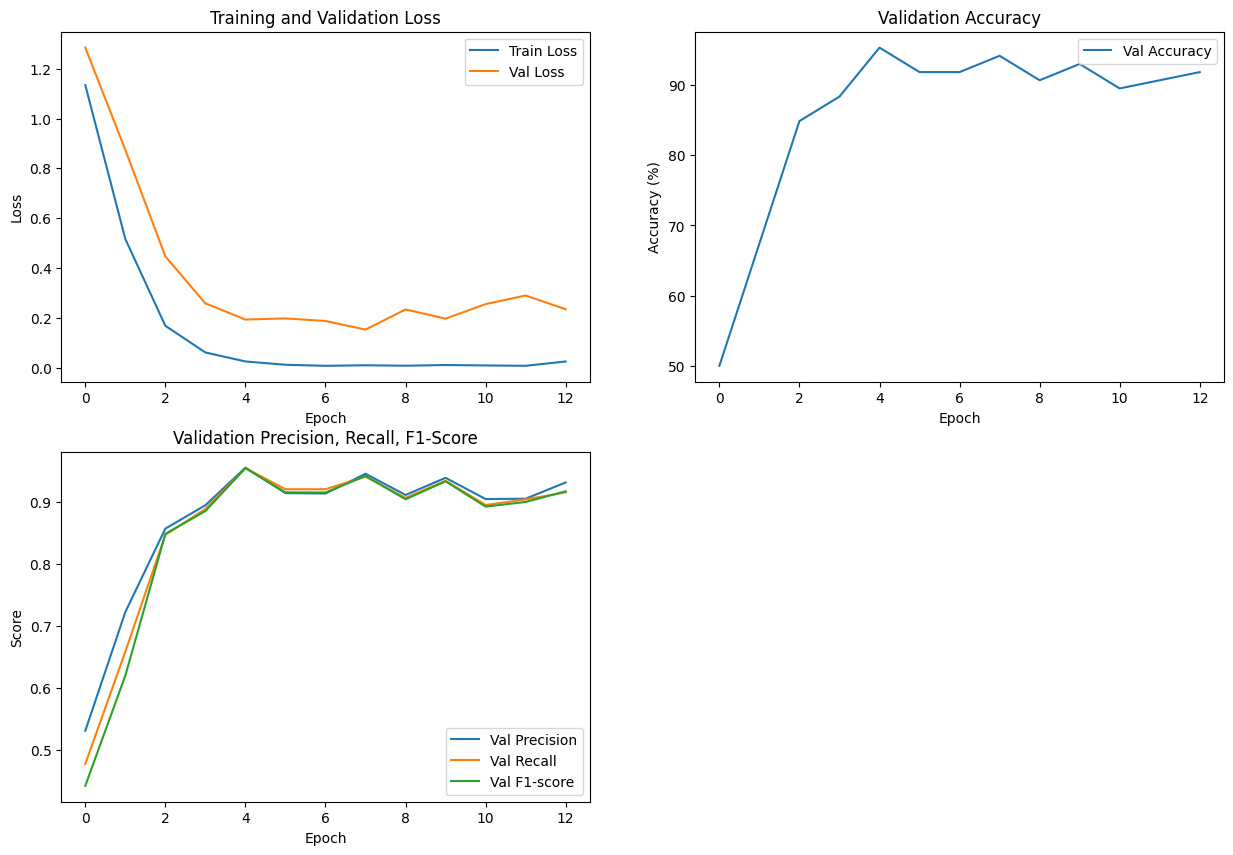

Accuracy on test set: 80.61%
Precision (macro): 0.8224
Recall (macro): 0.7971
F1-score (macro): 0.8010

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.64      0.74        22
  meningioma       0.58      0.78      0.67        23
     notumor       0.96      0.90      0.93        30
   pituitary       0.87      0.87      0.87        23

    accuracy                           0.81        98
   macro avg       0.82      0.80      0.80        98
weighted avg       0.83      0.81      0.81        98



In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(val_precisions, label='Val Precision')
plt.plot(val_recalls, label='Val Recall')
plt.plot(val_f1s, label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Precision, Recall, F1-Score')

plt.show()

#Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

precision = Precision(task="multiclass", num_classes=4, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=4, average='macro').to(device)
f1 = F1Score(task="multiclass", num_classes=4, average='macro').to(device)

all_preds_tensor = torch.tensor(all_preds).to(device)
all_labels_tensor = torch.tensor(all_labels).to(device)

prec_score = precision(all_preds_tensor, all_labels_tensor)
rec_score = recall(all_preds_tensor, all_labels_tensor)
f1_score = f1(all_preds_tensor, all_labels_tensor)

print(f'Precision (macro): {prec_score:.4f}')
print(f'Recall (macro): {rec_score:.4f}')
print(f'F1-score (macro): {f1_score:.4f}')

print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/2resnet50_cbam_finetuned.pth')

Refrence paper: Oladimeji, O. O., & Ibitoye, A. O. J. (2023). Brain tumor classification using ResNet50-convolutional block attention module. Applied Computing and Informatics. Emerald Publishing Limited. DOI: 10.1108/ACI-09-2023-0022